In [201]:
import os
import torch
import numpy as np
import util
import rans
from torch_vae.tvae_beta_binomial import BetaBinomialVAE
from torch_vae import tvae_utils
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt
from scipy.stats import norm, beta, binom
from scipy.special import gammaln

In [202]:
rng = np.random.RandomState(0)
np.seterr(over='raise')

prior_precision = 8
obs_precision = 14
q_precision = 14

num_images = 100

compress_lengths = []

latent_dim = 50
latent_shape = (1, latent_dim)

In [203]:
model = BetaBinomialVAE(hidden_dim=200, latent_dim=latent_dim)
model.load_state_dict(
    torch.load('torch_vae/saved_params/torch_vae_beta_binomial_params',
               map_location=lambda storage, location: storage))
model.eval()

rec_net = tvae_utils.torch_fun_to_numpy_fun(model.encode)
gen_net = tvae_utils.torch_fun_to_numpy_fun(model.decode)

obs_append = tvae_utils.beta_binomial_obs_append(255, obs_precision)
obs_pop = tvae_utils.beta_binomial_obs_pop(255, obs_precision)

vae_append = util.vae_append(latent_shape, gen_net, rec_net, obs_append,
                             prior_precision, q_precision)
vae_pop = util.vae_pop(latent_shape, gen_net, rec_net, obs_pop,
                       prior_precision, q_precision)

In [204]:
# load some mnist images
num_images=2

mnist = datasets.MNIST('data/mnist', train=False, download=True,
                       transform=transforms.Compose([transforms.ToTensor()]))
images = mnist.test_data[:num_images]

images = [image.float().view(1, -1) for image in images]

# randomly generate some 'other' bits
other_bits = rng.randint(low=1 << 16, high=1 << 31, size=50, dtype=np.uint32)
state = rans.unflatten(other_bits)

/home/reasatt/miniconda3/envs/bb/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [205]:
(1 << 8) +1

257

In [206]:
precision=3

In [207]:
np.arange((1 << precision) + 1) / (1 << precision)

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ])

In [208]:
np.arange(1 << precision+1) / (1 << precision)

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
       1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875])

In [209]:
norm.ppf(np.arange((1 << precision) + 1) / (1 << precision)).shape

(9,)

In [210]:
prior_prec=8
latent_prec=12
def gaussian_latent_cdf(mean, stdd, prior_prec, post_prec):
    def cdf(idx):
        x = std_gaussian_buckets(prior_prec)[idx]
        return _nearest_int(norm.cdf(x, mean, stdd) * (1 << post_prec))
    return cdf
def _nearest_int(arr):
    # This will break when vectorized
    return int(np.around(arr))
std_gaussian_bucket_cache = {}  # Stores bucket endpoints
def std_gaussian_buckets(precision):
    """
    Return the endpoints of buckets partioning the domain of the prior. Each
    bucket has mass 1 / (1 << precision) under the prior.
    """
    if precision in std_gaussian_bucket_cache:
#         print(std_gaussian_bucket_cache)
        return std_gaussian_bucket_cache[precision]
    else:
        buckets = np.float32(
            norm.ppf(np.arange((1 << precision) + 1) / (1 << precision)))
        std_gaussian_bucket_cache[precision] = buckets
#         print(std_gaussian_bucket_cache)
        return buckets

In [211]:
# std_gaussian_bucket_cache[8]

In [212]:
post_mean, post_stdd = rec_net(images[0])
post_mean, post_stdd = np.ravel(post_mean), np.ravel(post_stdd)
cdfs = [gaussian_latent_cdf(m, s, prior_prec, latent_prec)
                for m, s in zip(post_mean, post_stdd)]

In [213]:
x=std_gaussian_bucket_cache[8]

KeyError: 8

In [214]:
x

array([       -inf, -2.6600676 , -2.417559  , -2.2662268 , -2.1538746 ,
       -2.0635278 , -1.9874278 , -1.9213507 , -1.8627318 , -1.8098923 ,
       -1.7616704 , -1.7172282 , -1.6759397 , -1.6373254 , -1.6010087 ,
       -1.5666885 , -1.5341206 , -1.5031029 , -1.4734676 , -1.4450725 ,
       -1.4177971 , -1.3915375 , -1.3662038 , -1.3417178 , -1.3180109 ,
       -1.2950224 , -1.2726986 , -1.2509917 , -1.2298588 , -1.2092612 ,
       -1.1891644 , -1.1695366 , -1.1503494 , -1.1315765 , -1.1131942 ,
       -1.0951806 , -1.0775156 , -1.0601804 , -1.0431583 , -1.0264331 ,
       -1.0099902 , -0.9938159 , -0.9778975 , -0.9622232 , -0.94678175,
       -0.93156284, -0.91655666, -0.90175414, -0.88714653, -0.8727259 ,
       -0.85848445, -0.84441507, -0.83051085, -0.8167654 , -0.8031726 ,
       -0.7897265 , -0.7764218 , -0.76325303, -0.75021535, -0.737304  ,
       -0.72451437, -0.7118422 , -0.6992833 , -0.68683374, -0.67448974,
       -0.66224766, -0.65010405, -0.63805556, -0.626099  , -0.61

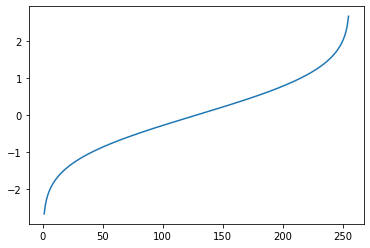

In [215]:
plt.plot(x)

In [216]:
post_mean[0]

0.4008764

In [217]:
post_stdd[1]

0.9930004

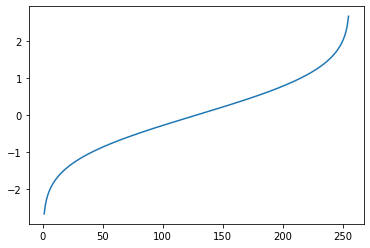

In [218]:
plt.plot(x)

# So the bucket range is -2.7 to 2.7, which is mapped to 0 - 256

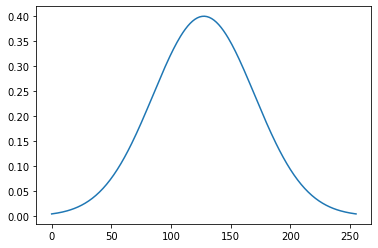

In [219]:
plt.plot(norm.pdf(np.linspace(-3,3,256),0,1))

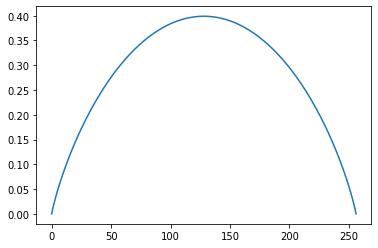

In [220]:
plt.plot(norm.pdf(x, 0, 1))

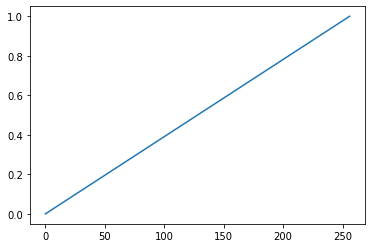

In [221]:
plt.plot(norm.cdf(x, 0, 1))

In [222]:
2**12

4096

# Mean and std per dim from encoder output

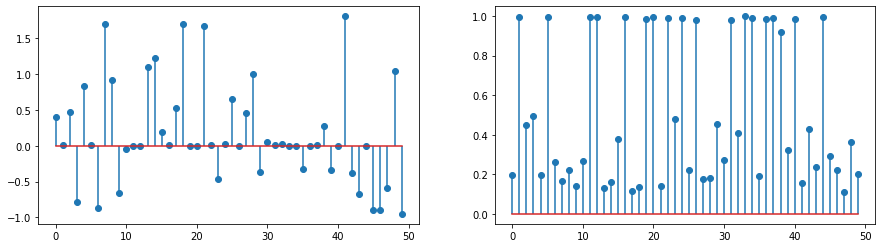

In [151]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.stem(post_mean,use_line_collection=True)
plt.subplot(1,2,2)
plt.stem(post_stdd,use_line_collection=True)
plt.show()

In [152]:
0.4*255

102.0

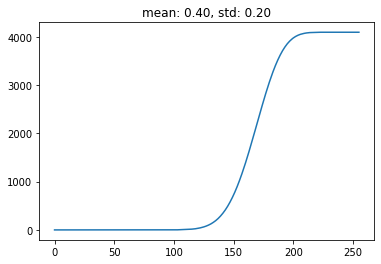

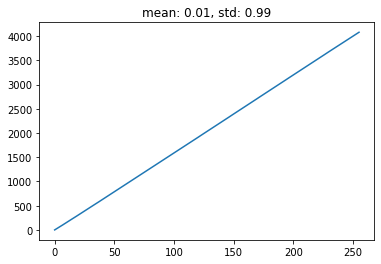

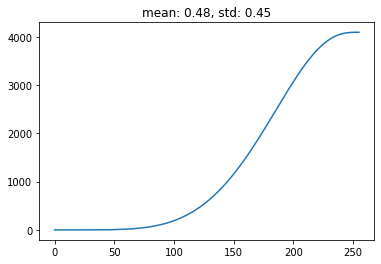

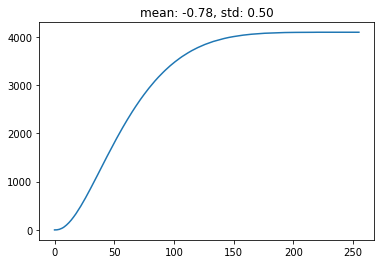

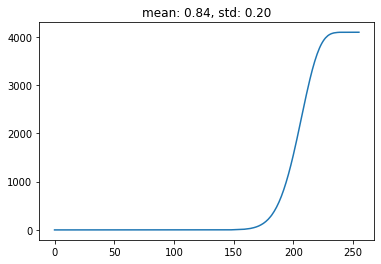

In [153]:
for i_cdf in range(5):
    cdf_dist = [cdfs[i_cdf](i) for i in range(1<<prior_prec)]
    plt.plot(range(1<<prior_prec),cdf_dist)
    plt.title('mean: {:.2f}, std: {:.2f}'.format(post_mean[i_cdf], post_stdd[i_cdf]))
    plt.show()

img:  1
appending data torch.Size([1, 784])


/home/reasatt/miniconda3/envs/bb/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


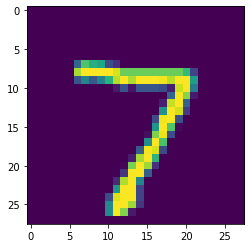

post_pop
non_uni_pop: popped symbols shape (50,)
[175, 192, 128, 11, 208, 254, 60, 244, 210, 70, 100, 252, 98, 222, 220, 178, 255, 174, 243, 44, 75, 244, 233, 85, 160, 207, 72, 182, 191, 103, 180, 180, 156, 215, 144, 101, 114, 126, 151, 83, 101, 246, 74, 52, 97, 27, 46, 88, 209, 36]
lik_append
input latent_idx (50,) [175 192 128  11 208 254  60 244 210  70 100 252  98 222 220 178 255 174
 243  44  75 244 233  85 160 207  72 182 191 103 180 180 156 215 144 101
 114 126 151  83 101 246  74  52  97  27  46  88 209  36]
transformed the latent_idx through a generator to obs_params: 
 2 (1, 784) [3.9360025e-06 4.2631536e-06 2.2446438e-06 3.4886784e-06 1.5844681e-06
 1.8692151e-06 2.4216470e-06 5.0185349e-06 2.6406731e-06 3.0660810e-06]
beta_binomials_append: 
appending the obs_params
a [3.9360025e-06 4.2631536e-06 2.2446438e-06 3.4886784e-06 1.5844681e-06
 1.8692151e-06 2.4216470e-06 5.0185349e-06 2.6406731e-06 3.0660810e-06],
b [150.72165  236.60295  155.4309   141.80083  142.39275  103.119

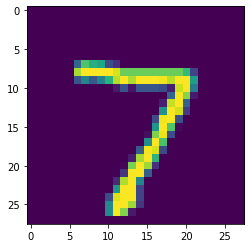

non_uniforms_append input symbols (784,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
prior_append
uniforms_append input symbols (50,)
[175 192 128  11 208 254  60 244 210  70 100 252  98 222 220 178 255 174
 243  44  75 244 233  85 160 207  72 182 191 103 180 180 156 215 144 101
 114 126 151  83 101 246  74  52  97  27  46  88 209  36]
Encoded 0
state len:  79
img:  2
appending data torch.Size([1, 784])


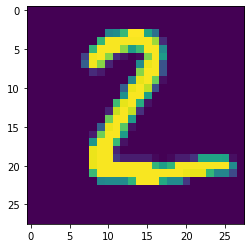

post_pop
non_uni_pop: popped symbols shape (50,)
[195, 89, 224, 157, 191, 226, 3, 26, 219, 20, 176, 67, 49, 126, 53, 186, 52, 29, 231, 22, 254, 14, 23, 201, 63, 239, 24, 221, 146, 35, 39, 205, 124, 198, 223, 84, 103, 28, 29, 57, 185, 17, 64, 248, 2, 188, 27, 103, 199, 98]
lik_append
input latent_idx (50,) [195  89 224 157 191 226   3  26 219  20 176  67  49 126  53 186  52  29
 231  22 254  14  23 201  63 239  24 221 146  35  39 205 124 198 223  84
 103  28  29  57 185  17  64 248   2 188  27 103 199  98]
transformed the latent_idx through a generator to obs_params: 
 2 (1, 784) [3.7356308e-06 2.8188394e-06 3.1600591e-06 3.7988395e-06 2.7989845e-06
 2.6446980e-06 3.1919224e-06 4.6196328e-06 5.8689966e-06 2.0081500e-06]
beta_binomials_append: 
appending the obs_params
a [3.7356308e-06 2.8188394e-06 3.1600591e-06 3.7988395e-06 2.7989845e-06
 2.6446980e-06 3.1919224e-06 4.6196328e-06 5.8689966e-06 2.0081500e-06],
b [106.96963  122.11796  156.00441  167.65395  218.34273  273.30334
 149.093

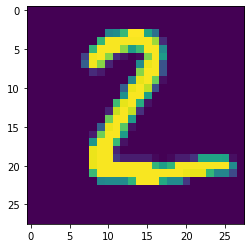

non_uniforms_append input symbols (784,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
prior_append
uniforms_append input symbols (50,)
[195  89 224 157 191 226   3  26 219  20 176  67  49 126  53 186  52  29
 231  22 254  14  23 201  63 239  24 221 146  35  39 205 124 198 223  84
 103  28  29  57 185  17  64 248   2 188  27 103 199  98]
state len:  118

All encoded in 1.05s
Used 2176 bits.
This is 1.39 bits per pixel
uni_pop: popped symbols shape (50,)
[195, 89, 224, 157, 191, 226, 3, 26, 219, 20, 176, 67, 49, 126, 53, 186, 52, 29, 231, 22, 254, 14, 23, 201, 63, 239, 24, 221, 146, 35, 39, 205, 124, 198, 223, 84, 103, 28, 29, 57, 185, 17, 64, 248, 2, 188, 27, 103, 199, 98]
non_uni_pop: popped symbols shape (784,)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
non_uniforms_append input symbols (50,)
[195  89 224 157 191 226   3 

In [4]:
print_interval = 10
encode_start_time = time.time()
for i, image in enumerate(images):
    print('img: ',i+1)
    state = vae_append(state, image)
#     if i==2:
#         break
#     '''
    if not i % print_interval:
        print('Encoded {}'.format(i))
    print('state len: ',len(rans.flatten(state)))
    compressed_length = 32 * (len(rans.flatten(state)) - len(other_bits)) / (i+1)
#     print('compressed_length_avg',compressed_length)
    compress_lengths.append(compressed_length)

print('\nAll encoded in {:.2f}s'.format(time.time() - encode_start_time))
compressed_message = rans.flatten(state)

compressed_bits = 32 * (len(compressed_message) - len(other_bits))
print("Used " + str(compressed_bits) + " bits.")
print('This is {:.2f} bits per pixel'.format(compressed_bits
                                             / (num_images * 784)))

if not os.path.exists('results'):
    os.mkdir('results')
np.savetxt('compressed_lengths_cts', np.array(compress_lengths))

state = rans.unflatten(compressed_message)
decode_start_time = time.time()

for n in range(len(images)):
    state, image_ = vae_pop(state)
    original_image = images[len(images)-n-1].numpy()
    np.testing.assert_allclose(original_image, image_)

    if not n % print_interval:
        print('Decoded {}'.format(n))

print('\nAll decoded in {:.2f}s'.format(time.time() - decode_start_time))

recovered_bits = rans.flatten(state)
assert all(other_bits == recovered_bits)
# '''

In [11]:
image_

tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,  

In [12]:
original_image

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

In [5]:
state

(900731659723581999,
 (924296821,
  (1478675648,
   (441430851,
    (1537430267,
     (192837315,
      (1491500391,
       (1819649033,
        (530767571,
         (626675989,
          (1650972402,
           (1879488292,
            (1277966935,
             (1682717766,
              (243645912,
               (1991481944,
                (1171115404,
                 (1646934330,
                  (2051621569,
                   (1253015014,
                    (1340820007,
                     (124168279,
                      (2061551790,
                       (292314712,
                        (1687063377,
                         (1827989157,
                          (1443512857,
                           (305163085,
                            (1449171016,
                             (374283017,
                              (636458900,
                               (86902899,
                                (1581650896,
                                 (1428656883,
  

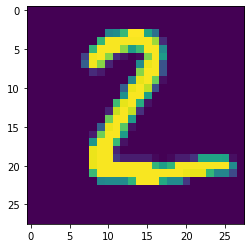

In [6]:
plt.imshow(image.reshape(28,28))

In [7]:
uniform_enc_statfun = lambda s: (s, 1)

In [8]:
uniform_enc_statfun(3)

(3, 1)

In [9]:
uniform_dec_statfun = lambda cf: (cf, (cf, 1))

In [10]:
uniform_dec_statfun(3)

(3, (3, 1))